In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import datetime, os
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import ResNet50, ResNet152, ResNet50V2, ResNet152V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet import preprocess_input
from keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

c:\Users\Dell\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset_path = ""

In [4]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range=0.2,
                fill_mode='nearest', 
                validation_split=0.2
)

In [5]:
train_gen = train_datagen.flow_from_directory(dataset_path+'Dataset',
                                              target_size = (224,224),
                                              batch_size=2,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=4,
                                              interpolation='bilinear',
                                              subset='training'
                                              )

valid_gen = train_datagen.flow_from_directory(dataset_path+'Dataset',
                                              target_size = (224,224),
                                              batch_size=2,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=4,
                                              interpolation='bilinear',
                                              subset='validation'
                                              )

Found 391 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [6]:

train_data = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.float32),
                                            output_shapes=([None
                                                            , 224, 224, 3]
                                                            , [None, train_gen.num_classes])
                                            )
val_data = tf.data.Dataset.from_generator(lambda: valid_gen,
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([None
                                                          , 224, 224, 3]
                                                          , [None, valid_gen.num_classes])
                                          )

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


(224, 224, 3)


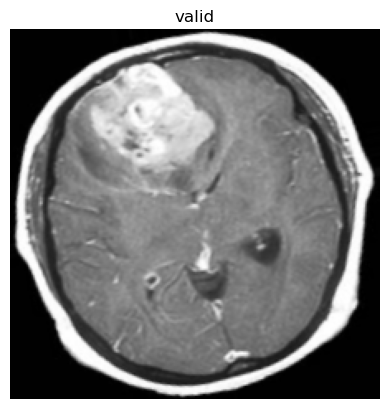

In [6]:
# Get a batch of data from the iterator
img, label = next(valid_gen)

# Print the shape of the first image
print(img[0].shape)

# Display the first image
plt.imshow(img[0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('valid')
plt.show()


In [7]:

waktu =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("MRI-logs", waktu)
logdir = os.path.join("logs", waktu)
     

In [8]:
IMG_SHAPE = (224, 224, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

In [10]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1000, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(320, activation='relu')(x)
x=Dropout(0.2)(x)
preds=Dense(5, activation='softmax')(x)

In [11]:

model=Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,860,909 (14.73 MB)

 Trainable params: 1,602,925 (6.11 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
model.compile(optimizer='SGD', loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
pip install --upgrade tensorflow
pip install --upgrade keras


SyntaxError: invalid syntax (1365445930.py, line 1)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import datetime
import os
# Define the dimensions of your input images
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Assuming you have defined your base model
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 model without top (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

# Add a GlobalAveragePooling2D layer to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dense layer with a single neuron for binary classification
predictions = Dense(2, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
              metrics=['accuracy'])

# Define callbacks
waktu = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
epochs = 15

os.makedirs("MRI-logs", exist_ok=True)
logdir = os.path.join("MRI-logs", waktu)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode='max',
                                                 min_delta=0.01,
                                                 patience=3,
                                                 factor=0.25,
                                                 verbose=1,
                                                 cooldown=0,
                                                 min_lr=0.00000001)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 mode='max',
                                                 min_delta=0.005,
                                                 patience=10,
                                                 verbose=1,
                                                 restore_best_weights=True)

# Assuming you have defined your train_gen and valid_gen data generators
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen,
                    callbacks=[early_stopper, reduce_lr, tensorboard_callback])

# Save the model
model_dir = "model-MRI/2M" + str(waktu) + ".h5"
model.save(model_dir)


Epoch 1/15


c:\Users\Dell\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6323 - loss: 0.6503

c:\Users\Dell\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.6330 - loss: 0.6496 - val_accuracy: 0.9175 - val_loss: 0.2917 - learning_rate: 0.0010
Epoch 2/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.9010 - loss: 0.3056 - val_accuracy: 0.9381 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 3/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9324 - loss: 0.2098 - val_accuracy: 0.9691 - val_loss: 0.1900 - learning_rate: 0.0010
Epoch 4/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9497 - loss: 0.1816 - val_accuracy: 0.9485 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 5/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.9656 - loss: 0.1566 - val_accuracy: 0.9175 - val_loss: 0.2067 - learning_rate: 0.0010
Epoch 6/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9571 - loss: 0.1522
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.9572 - loss: 0.15

In [14]:
loss, acc = model.evaluate(train_data,steps=len(train_gen),verbose=0)
print('Accuracy of Train data: {:.4f} | Loss : {:.4f}'.format(acc,loss),'  ')

loss, acc = model.evaluate(val_data,steps=len(valid_gen),verbose=0)
print('Accuracy of Test data : {:.4f} | Loss : {:.4f}'.format(acc,loss),'  ')

Accuracy of Train data: 0.9693 | Loss : 0.1253   
Accuracy of Test data : 0.9794 | Loss : 0.1425   


In [13]:
model = load_model('model-MRI/2M20240412-095141.h5')

In [16]:
probabilitas = model.predict(valid_gen)
prediction = np.argmax(probabilitas, axis=1)
label = valid_gen.classes
cm=confusion_matrix(label, prediction)

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step


In [17]:
kelas = valid_gen.class_indices

In [18]:
prediction

array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [19]:
def load_image(img_path, show=True):
    
    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                   
    img_tensor = np.expand_dims(img_tensor, axis=0)          
    img_tensor /= 255.                                     
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [20]:
def predict(new_img):
    path_img = load_image(new_img)
    pre = model.predict(path_img).transpose()
    return pre

In [26]:
categories = ('no','yes')

def classify_images(img):
  pred = predict(img)
  return dict(zip(categories, map(float,pred)))

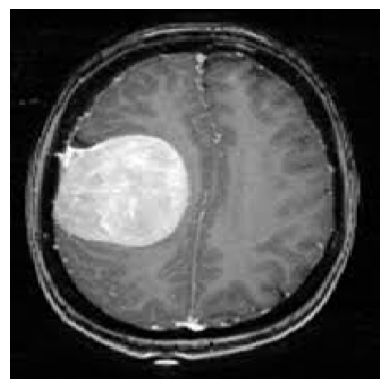

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


C:\Users\Dell\AppData\Local\Temp\ipykernel_21332\2198062239.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return dict(zip(categories, map(float,pred)))


{'no': 0.009152546525001526, 'yes': 0.9883158802986145}

In [27]:
classify_images("D:/5th_sem/machine_learning/Dataset/yes/Y1.jpg")

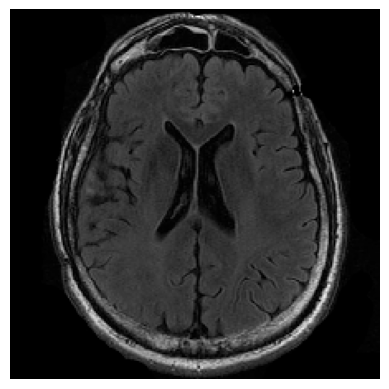

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


C:\Users\Dell\AppData\Local\Temp\ipykernel_21332\2198062239.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return dict(zip(categories, map(float,pred)))


{'no': 0.8229374289512634, 'yes': 0.07461095601320267}

In [28]:
classify_images("D:/5th_sem/machine_learning/Dataset/no/7 no.jpg")

In [14]:
import tensorflow as tf

# Assume 'model' is your pre-trained TensorFlow Keras model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the optimization flag to optimize for size.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# To further enable integer-only quantization, you can set the representative dataset
# This step is crucial for full integer quantization, it helps the converter
# to properly quantize input/output and intermediate tensors.
def representative_data_gen():
    for input_value in dataset.take(100):  # Assuming 'dataset' is tf.data.Dataset object
        yield [input_value]

converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs may vary by TensorFlow version)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert the model
tflite_model = converter.convert()

# Save the model to a file
with open("coconut.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model has been successfully converted and optimized.")


INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpvorbhplx\assets


INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpvorbhplx\assets


: 

In [1]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("coconut.tflite", "wb").write(tflite_model)

NameError: name 'tf' is not defined

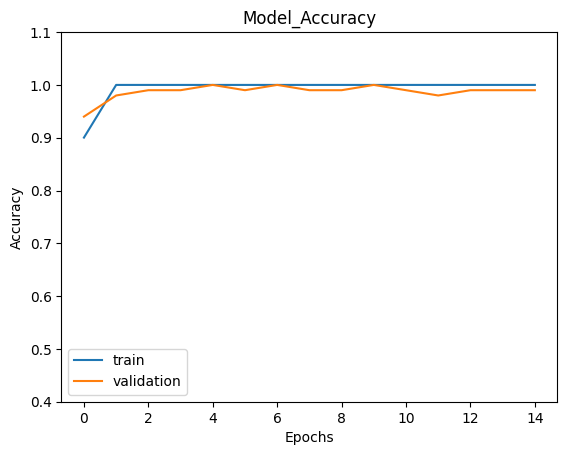

In [13]:
figl=plt.gcf()
plt.plot (history.history['accuracy'])
plt.plot (history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1.1)
plt.grid(False)
plt.title('Model_Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

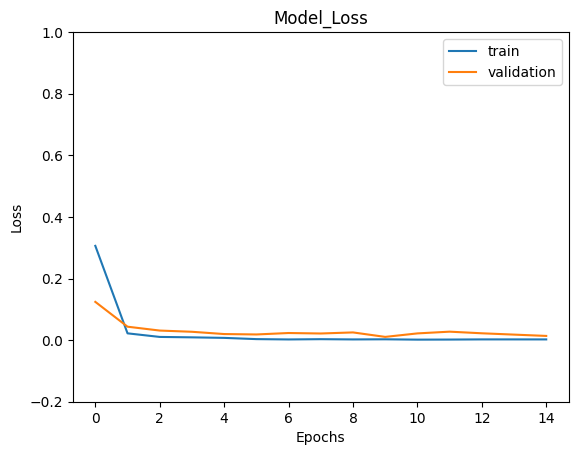

In [14]:
figl=plt.gcf()
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.axis(ymin=-0.2, ymax=1)
plt.grid(False)
plt.title('Model_Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()